In [154]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns 
from sklearn import linear_model
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBRegressor
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

In [170]:
AQS = "/Users/matthewq/Geol_599/week7/LA_AQS_2023.csv" 
df = pd.read_csv(AQS) 

In [171]:
# Create an "ozone only" data frame
df_O3 = df[(df['Parameter Name']=='Ozone') & (df['Duration Description']=='1 HOUR')]
df_O3.head()
o3V = df_O3["Arithmetic Mean"]
df_O3 = pd.DataFrame(data = {"O3" : o3V, 'date' : df_O3["Date (Local)"]})

In [172]:
#create no2 only data set
df_NO2 = df[(df['Parameter Name']=='Nitrogen dioxide (NO2)') & (df['Duration Description']=='1 HOUR')]
df_NO2.head()
no2V = df_NO2["Arithmetic Mean"]
df_NO2 = pd.DataFrame(data = {"NO2" : no2V, 'date' : df_NO2["Date (Local)"]})

In [173]:
#create pm2.5 only data set
df_PM25 = df[(df['Parameter Name']=='PM2.5 - Local Conditions') & (df['Duration Description']=='1 HOUR')]
df_PM25.head()
pm25V = df_PM25["Arithmetic Mean"]
df_PM25 = pd.DataFrame(data = {"PM" : pm25V, 'date' : df_PM25["Date (Local)"]})

In [176]:
oz_n = df_NO2.merge(df_O3, on=['date'])
oz_n_pm = df_PM25.merge(oz_n, on=['date'])

In [175]:
#1- determining summer months
#use .values to get array of 1 through 9 for each month
Months = pd.DatetimeIndex(oz_n_pm['date']).month.values

In [ ]:
#encoding summer as 1, winter as 0, neither as -1
#creates empty array 
sIdx = Months - Months #Set values (including winter) to zero
sIdx[Months == 12] = 0 #Set winter to 0
sIdx[Months == 1] = 0
sIdx[Months == 2] = 0

sIdx[Months == 6] = 1 #Set summer to 1
sIdx[Months == 7] = 1
sIdx[Months == 8] = 1

sIdx[Months == 3] = -1 #Set spring to -1
sIdx[Months == 4] = -1
sIdx[Months == 5] = -1

sIdx[Months == 9] = -1 #Set fall to -1
sIdx[Months == 10] = -1
sIdx[Months == 11] = -1

In [177]:
oz_n_pm['season'] = sIdx

In [178]:
oz_n_pm = oz_n_pm[oz_n_pm['season'] > -1]

In [63]:
X = oz_n_pm[["NO2", "PM", "O3"]].to_numpy()
y = oz_n_pm["season"]

In [135]:
features = ["NO2", "PM", "O3"]
featuresdf = pd.DataFrame(np.hstack((features)), columns = ['feature'])
featuresdf

,feature
0,NO2
1,PM
2,O3


In [64]:
from sklearn.model_selection import train_test_split
#Splitting data set - test = 10% of data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

#splitting training data set further to get validation set (15% of whole data set) leaving training set 75% of whole data set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17)

In [65]:
alphas = np.arange(0, 1.05, 0.05).tolist()

In [66]:
for i in alphas:
    seasonClassifier = RidgeClassifier(alpha=i)
    seasonClassifier.fit(X_train, y_train)
    print(seasonClassifier.score(X_test, y_test))

0.8688524590163934
0.8688524590163934
0.8360655737704918
0.8360655737704918
0.8524590163934426
0.8524590163934426
0.8524590163934426
0.8524590163934426
0.8524590163934426
0.8524590163934426
0.8524590163934426
0.8524590163934426
0.8524590163934426
0.8524590163934426
0.8524590163934426
0.8524590163934426
0.8524590163934426
0.8524590163934426
0.8524590163934426
0.8524590163934426
0.8524590163934426


In [67]:
for i in alphas:
    seasonClassifier = RidgeClassifier(alpha=i)
    seasonClassifier.fit(X_val, y_val)
    print(seasonClassifier.score(X_val, y_val))

0.8602150537634409
0.8817204301075269
0.8817204301075269
0.8817204301075269
0.8817204301075269
0.8817204301075269
0.8817204301075269
0.8817204301075269
0.8817204301075269
0.8817204301075269
0.8817204301075269
0.8817204301075269
0.8817204301075269
0.8817204301075269
0.8817204301075269
0.8817204301075269
0.8817204301075269
0.8817204301075269
0.8817204301075269
0.8817204301075269
0.8817204301075269


In [68]:
#5- Final Model, alpha of 0.05 determined as optimal above
seasonClassifier = RidgeClassifier(alpha=0.05)
sea = seasonClassifier.fit(X_train, y_train)
print(seasonClassifier.score(X_test, y_test))

0.8688524590163934


In [69]:
#Importing permutation importance
from sklearn.inspection import permutation_importance

In [70]:
r = permutation_importance(sea, X_test, y_test, n_repeats=10, random_state=0)

In [71]:
r

{'importances_mean': array([0.19836066, 0.12622951, 0.00983607]),
 'importances_std': array([0.04045562, 0.04018902, 0.01825497]),
 'importances': array([[ 0.13114754,  0.14754098,  0.2295082 ,  0.18032787,  0.27868852,
          0.19672131,  0.19672131,  0.21311475,  0.18032787,  0.2295082 ],
        [ 0.16393443,  0.13114754,  0.13114754,  0.1147541 ,  0.14754098,
          0.1147541 ,  0.1147541 ,  0.03278689,  0.19672131,  0.1147541 ],
        [ 0.01639344,  0.03278689, -0.01639344, -0.01639344,  0.        ,
          0.        ,  0.01639344,  0.03278689,  0.        ,  0.03278689]])}

In [72]:
r.importances_mean

array([0.19836066, 0.12622951, 0.00983607])

In [73]:
r.importances_std

array([0.04045562, 0.04018902, 0.01825497])

In [94]:
for i in range(len(r.importances_mean)):
    print(f"{features[i]}: {r.importances_mean[i]:.3f} +/- {r.importances_std[i]:.3f}")

NO2: 0.198 +/- 0.040
PM: 0.126 +/- 0.040
O3: 0.010 +/- 0.018


In [132]:
imp_means = pd.DataFrame(np.hstack((r.importances_mean)), columns = ['mean'])
imp_std = pd.DataFrame(np.hstack((r.importances_std)), columns = ['std'])

,mean
0,0.198361
1,0.126230
2,0.009836


In [145]:
feature_imp = [featuresdf, imp_means, imp_std]
imp_df = feature_imp[0].join(feature_imp[1:])
imp_df

,feature,mean,std
0,NO2,0.198361,0.040456
1,PM,0.126230,0.040189
2,O3,0.009836,0.018255


[Text(0.5, 0, 'Feature'), Text(0, 0.5, 'Importance Mean')]

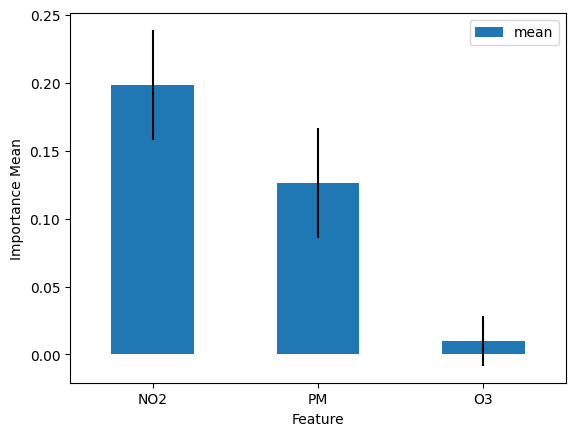

In [152]:
ax = imp_df.plot(kind='bar', x='feature', y='mean', yerr='std', rot=0)
ax.set(xlabel='Feature', ylabel='Importance Mean')

In [161]:
#Buoy Data
buoy = pd.read_csv("/Users/matthewq/Geol_599/week9/Waves_2023.txt", sep='\s+') 
buoy_use = buoy[['WVHT', 'DPD', 'APD', 'MWD', 'WTMP']].copy()
X = buoy_use[["DPD", "APD", "MWD", 'WTMP']].to_numpy()
y = buoy_use[['WVHT']]

#Splitting data set - test = 10% of data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

#splitting training data set further to get validation set (15% of whole data set) leaving training set 75% of whole data set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17)

In [162]:
wave_features = ["DPD", "APD", "MWD", 'WTMP'] #dominant wave period, average wave period, wave direction, water temperature
wave_featuresdf = pd.DataFrame(np.hstack((wave_features)), columns = ['feature'])
wave_featuresdf

,feature
0,DPD
1,APD
2,MWD
3,WTMP


In [163]:
#Boosted regression learning rate determined in HW9
bst = XGBRegressor(n_estimators=25, learning_rate=0.4)
bst = bst.fit(X_train, y_train)

r_bst = permutation_importance(bst, X_test, y_test, n_repeats=10, random_state=0)
r_bst

{'importances_mean': array([1.89513958, 0.02494072, 0.02054188, 0.01855603]),
 'importances_std': array([0.00605601, 0.00120765, 0.00108588, 0.00147004]),
 'importances': array([[1.89411854, 1.89473346, 1.89408503, 1.90491799, 1.88269487,
         1.89134358, 1.89522911, 1.89523423, 1.89398995, 1.90504902],
        [0.02415566, 0.02704359, 0.02456835, 0.02412206, 0.0258142 ,
         0.02471591, 0.02382305, 0.02530282, 0.02673949, 0.02312204],
        [0.02035305, 0.0226077 , 0.01956667, 0.02116102, 0.02107276,
         0.01947357, 0.01952616, 0.02068798, 0.01913009, 0.02183975],
        [0.01703729, 0.01853295, 0.02135234, 0.0206991 , 0.01750913,
         0.01826395, 0.01665148, 0.01803575, 0.01967309, 0.01780522]])}

In [164]:
imp_means_bst = pd.DataFrame(np.hstack((r_bst.importances_mean)), columns = ['mean'])
imp_std_bst = pd.DataFrame(np.hstack((r_bst.importances_std)), columns = ['std'])

feature_imp_bst = [wave_featuresdf, imp_means_bst, imp_std_bst]
bst_imp_df = feature_imp_bst[0].join(feature_imp_bst[1:])
bst_imp_df

,feature,mean,std
0,DPD,1.895140,0.006056
1,APD,0.024941,0.001208
2,MWD,0.020542,0.001086
3,WTMP,0.018556,0.001470


[Text(0.5, 0, 'Feature'), Text(0, 0.5, 'Importance Mean')]

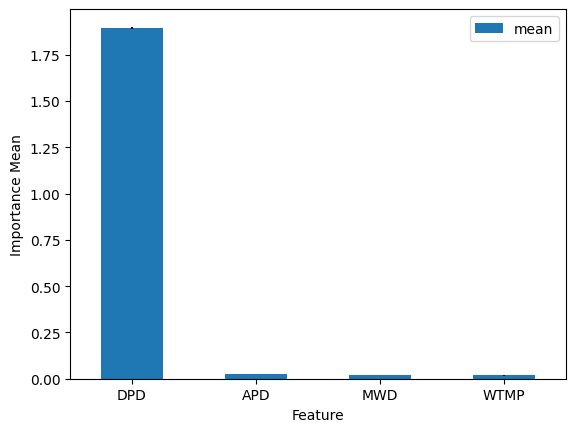

In [165]:
bst_ax = bst_imp_df.plot(kind='bar', x='feature', y='mean', yerr='std', rot=0)
bst_ax.set(xlabel='Feature', ylabel='Importance Mean')

In [166]:
#Decision Tree
DTrg = DecisionTreeRegressor()
DTrg.fit(X_train, y_train)

r_dt = permutation_importance(DTrg, X_test, y_test, n_repeats=10, random_state=0)

imp_means_dt = pd.DataFrame(np.hstack((r_dt.importances_mean)), columns = ['mean'])
imp_std_dt = pd.DataFrame(np.hstack((r_dt.importances_std)), columns = ['std'])

feature_imp_dt = [wave_featuresdf, imp_means_dt, imp_std_dt]
dt_imp_df = feature_imp_dt[0].join(feature_imp_dt[1:])
dt_imp_df

,feature,mean,std
0,DPD,0.026236,0.001404
1,APD,1.941568,0.008618
2,MWD,0.032458,0.002838
3,WTMP,0.023453,0.002595


[Text(0.5, 0, 'Feature'), Text(0, 0.5, 'Importance Mean')]

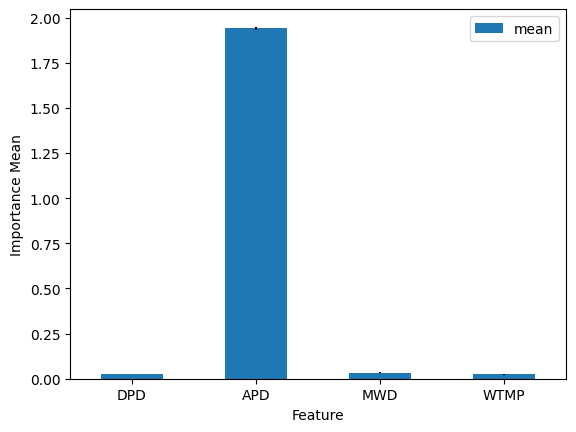

In [167]:
dt_ax = dt_imp_df.plot(kind='bar', x='feature', y='mean', yerr='std', rot=0)
dt_ax.set(xlabel='Feature', ylabel='Importance Mean')

In [168]:
#Linear Regression
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

r_reg = permutation_importance(reg, X_test, y_test, n_repeats=10, random_state=0)

imp_means_reg = pd.DataFrame(np.hstack((r_reg.importances_mean)), columns = ['mean'])
imp_std_reg = pd.DataFrame(np.hstack((r_reg.importances_std)), columns = ['std'])

feature_imp_reg = [wave_featuresdf, imp_means_reg, imp_std_reg]
reg_imp_df = feature_imp_reg[0].join(feature_imp_reg[1:])
reg_imp_df

,feature,mean,std
0,DPD,0.018660,0.002807
1,APD,0.849940,0.017361
2,MWD,0.109442,0.006814
3,WTMP,0.010476,0.002071


[Text(0.5, 0, 'Feature'), Text(0, 0.5, 'Importance Mean')]

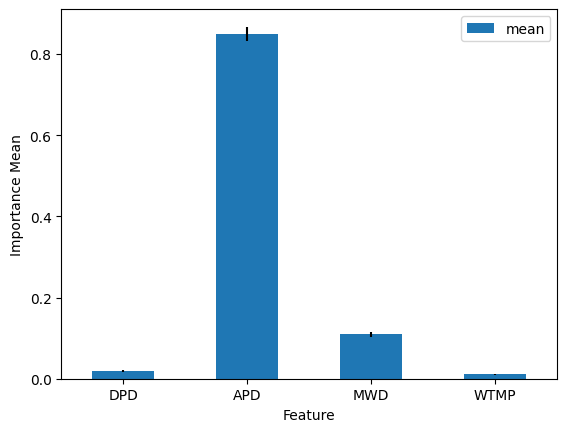

In [169]:
reg_ax = reg_imp_df.plot(kind='bar', x='feature', y='mean', yerr='std', rot=0)
reg_ax.set(xlabel='Feature', ylabel='Importance Mean')

The most important variable does change depending on the model used to predict wave height. The most important for teh XGBoost model is the dominant wave period, where the most important value for the decision tree and linear regression models is the average wave period.

Questions on Flora et al., 2024

1. The permutation importance method is described in the paper as the most common way to measure model-specific feature importance. This method evaluates the change in a models performance after permuting a feature's values. This maintains the feature's marginal distribution, or the probability distribution of the features values, but breaks up the relationship with the target variable. Some drawbacks of this method is that it alters the conditional joint distribution among features and it is restricted to specific ML alkgorithms, like random forests, or they get computationally restrictive. 

2. Another method described in the paper is the Local Interpretable Model-agnostic Explanations Method (LIME), which, as the name suggests, is model-agnostic. This method works by fitting a linear model on perturbations of the dataset and uses the model coefficients to generate the individual feature contributions. The 'width' of the local area where the perturbations are generated is dictated by a kernel function. There are some drawbacks to this approach, mainly that this method cannot guarantee local accuracy, can provide misleading explanations when dealing with correlated features and is subject to the accuracy of the local linear model.

3. Scikit functions: From Flora and Handler, 2022
First need to import scikit-explain 
-import skexplain

Permutation Importance:
-perm_results = explainer.permutation_importance(n_vars=10, evaluation_fn='auc')
-explainer.plot_importance(data=perm_results)

PD and ALE: 
#Assumes the .permutation_importance has already been run.
-important_vars = explainer.get_important_vars(results, multipass=True, nvars=7)

-ale = explainer.ale(features=important_vars, n_bins=20)

SHAP, LIME, and Tree Interpreter:
-import shap
    
#For the LIME, we must provide the training dataset. We also denote any categorical features. 
-lime_kws = {'training_data' : X.values, 'categorical_names' : ['rural', 'urban']}
    
#The masker handles the missing features. In this case, we are using correlations 
in the dataset to determine the feature groupings. These groups of features are remove or added into 
sets together. 
-shap_kws={'masker' : shap.maskers.Partition(X, max_samples=100, clustering="correlation"), 'algorithm' : 'permutation'}
           
#Method can be a single str or list of strs.
-attr_results = explainer.local_attributions(method=['shap', 'lime', 'tree_interpreter'], shap_kws=shap_kws, lime_kws=lime_kws)

-explainer = skexplain.ExplainToolkit(estimators=estimators[0],X=X, y=y)

#average_attributions is used to average feature attributions and their feature values either using a simple mean or the mean based on model performance. 
-avg_attr_results = explainer.average_attributions(method='shap', shap_kwargs=shap_kwargs, performance_based=True,)
-fig = myInterpreter.plot_contributions(avg_attr_results)
    
-attr_results = explainer.local_attributions(method='lime', lime_kws=lime_kws)
-explainer.scatter_plot(plot_type = 'summary', dataset=attr_results) 